In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, triang
from matplotlib import cm
from mpl_toolkits import mplot3d

This example demonstrates how to use grid approximation for Bayesian model comparison. In this example, we know that a given currency minting company has two factories $m=\{1,2\}$ that generates coins with different biases.

- The bias in the first factory is distributed around a mode of $\omega_1=0.25$ with a concentration of $\kappa=12$. Therefore, the coin biases from the first factory are distributed as $\theta\sim beta(\theta|\omega_1(\kappa-2) + 1, (1-\omega_1)(\kappa-2) + 1) = beta(\theta|3.5, 8.5)$
- The bias in the second factory is distributed around a mode of $\omega_2=0.75$ with a concentration of $\kappa=12$. Therefore, the coin biases from the second factory are distributed as $\theta\sim beta(\theta|\omega_2(\kappa-2) + 1, (1-\omega_2)(\kappa-2) + 1) = beta(\theta|8.5, 3.5)$

The prior distribution is calculated as:

$p(\theta, \omega, m) = p(\theta|\omega)p(\omega|m)p(m)$

where $p(m)$ should be a categorical distribution but we are representing as a mixture of two triangular distributions instead so we can add some volume to the plots. 

In [2]:
# This function calculates the prior, likelihood and posterior distributions from the selected parameters
#
# The parameters parameter is a dictionary with the following fields:
def calculate_pdfs(paremeters, granularity = 100):
    theta = np.linspace(0, 1, granularity)
    omega = np.linspace(0, 1, granularity)
    width_t = theta[1]
    width_w = omega[1]
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    triangular = triang(c = 0.5, loc = parameters['w'][0] - 0.025, scale = 0.05).pdf(OMEGA) * parameters['m'][0] + \
                 triang(c = 0.5, loc = parameters['w'][1] - 0.025, scale = 0.05).pdf(OMEGA) * parameters['m'][1]
    triangular = triangular / (np.sum(np.sum(triangular)) * width_t * width_w)
    prior = np.multiply(beta.pdf(THETA, 
                                 OMEGA * (parameters['k'] - 2) + 1, 
                                 (1 - OMEGA) * (parameters['k'] - 2) + 1), 
                        triangular)
    
    prior = prior / (np.sum(np.sum(prior)) * width_t * width_w)
    likelihood = np.multiply(np.power(THETA, parameters['z']), np.power(1 - THETA, parameters['n'] - parameters['z']))
    posterior = np.multiply(prior, likelihood) 
    posterior = posterior / (np.sum(np.sum(posterior)) * width_t * width_w)
    
    return theta, omega, prior, likelihood, posterior

In [3]:
# Plots the top or bottom section of the figure, i.e. the prior and the posterior sections
# The pdf parameter is either the priors or the posteriors calculated by the function above
# If parameters is assigned the parameters dictionary, the function will be assuming that it is plotting
# the top section (prior) and will adapt the label accordingly
def plot_prior_posterior(pdf, theta, omega, parameters = None):
    width_t = theta[1]
    THETA, OMEGA = np.meshgrid(theta, omega)
    marginal_theta = np.sum(pdf, axis = 0) / pdf.shape[1]
    marginal_omega = np.sum(pdf, axis = 1) / pdf.shape[0]
    marginal_theta_w_075 = pdf[75, :] / (np.sum(pdf[75, :]) * width_t)
    marginal_theta_w_025 = pdf[25, :] / (np.sum(pdf[25, :]) * width_t)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(4, 3)
    
    ax1 = fig.add_subplot(gs[0:2, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, pdf, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('prior')
    
    ax2 = fig.add_subplot(gs[0:2, 1])
    ax2.contourf(THETA, OMEGA, pdf, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')
    
    ax3 = fig.add_subplot(gs[0:2, 2])
    ax3.plot(marginal_omega, omega)
    ax3.set_xlabel(r'Marginal $p(\omega)$')
    ax3.set_ylabel(r'$\omega$')

    ax4 = fig.add_subplot(gs[2:4, 0])
    ax4.axis('off')
    if parameters is not None:
        parameters_str = 'K = ' + \
                         str(parameters['k'])
        ax4.text(1.1, 0.65, 'Prior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')
        ax4.text(1.1, 0.4, parameters_str, transform = ax4.transAxes, fontsize = 12, horizontalalignment = 'right')
    else:
        ax4.text(1.1, 0.65, 'Posterior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')

    ax5 = fig.add_subplot(gs[2:4, 1])
    ax5.plot(theta, marginal_theta)
    ax5.set_xlabel(r'$\theta$')
    ax5.set_ylabel(r'Marginal $p(\theta)$')

    ax6 = fig.add_subplot(gs[2, 2])
    ax6.plot(theta, marginal_theta_w_075)
    ax6.set_xlabel(r'$\theta$')
    ax6.set_ylabel(r'$p(\theta|\omega=.75)$')

    ax7 = fig.add_subplot(gs[3, 2])
    ax7.plot(theta, marginal_theta_w_025)
    ax7.set_xlabel(r'$\theta$')
    ax7.set_ylabel(r'$p(\theta|\omega=.25)$')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

In [4]:
# Plots the medium section of the figure (likelihood)
def plot_likelihood(likelihood, theta, omega, parameters):
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, likelihood, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('likelihood')

    ax2 = fig.add_subplot(gs[:, 1])
    ax2.contourf(THETA, OMEGA, likelihood, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[:, 2])
    ax3.axis('off')
    data_str = 'D = ' + str(parameters['z']) + ' heads, ' + str(parameters['n'] - parameters['z']) + ' tails'
    ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
    ax3.text(0, 0.4, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(2.5)
    plt.tight_layout()

In [5]:
# Plots the complete figure given a set of parameters (see the definition of the
# calculate_pdfs function for a description of this parameter)
def plot_figure(parameters):
    theta, omega, prior, likelihood, posterior =  calculate_pdfs(parameters)

    axes_prior = plot_prior_posterior(prior, theta, omega, parameters)
    plot_likelihood(likelihood, theta, omega, parameters)
    axes_posterior = plot_prior_posterior(posterior, theta, omega)

    maximum = max(axes_prior[2].get_xlim()[1],
                  axes_posterior[2].get_xlim()[1],
                  axes_prior[3].get_ylim()[1],
                  axes_posterior[3].get_ylim()[1])
    
    maximum2 = max(axes_prior[4].get_ylim()[1],
                   axes_posterior[4].get_ylim()[1])
 
    axes_prior[2].set_xlim([0, maximum])
    axes_posterior[2].set_xlim([0, maximum])
    axes_prior[3].set_ylim([0, maximum])
    axes_prior[4].set_ylim([0, maximum2])
    axes_posterior[3].set_ylim([0, maximum])
    axes_posterior[4].set_ylim([0, maximum2])

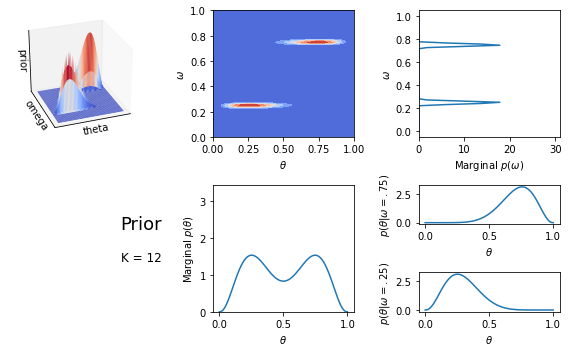

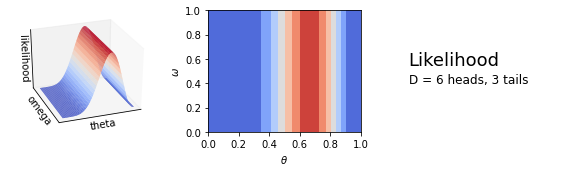

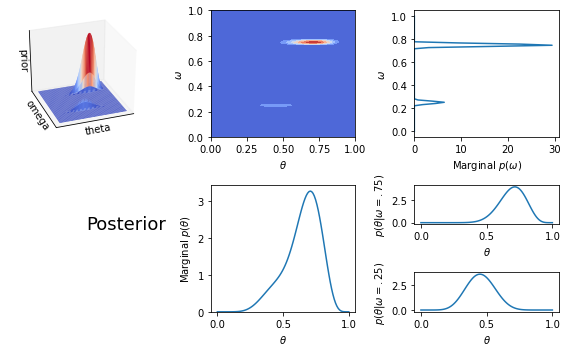

In [6]:
parameters = {
    'm': [0.5, 0.5],
    'w': [0.25, 0.75],
    'k': 12,
    'm': [0.5, 0.5],
    'n': 9,
    'z': 6
}

plot_figure(parameters)